# Operators and Matrices

In this tutorial we explain how the hyperbolic graph structure generated by hypertiling can be used to construct lattice operators. You will learn how the standard (listed) neighbour format can be easily transferred into adjacency and degree matrices, convientinly encoded in scipy's sparse matrix format. This allows to construct discrete (finite-difference) representation of several second order differential operators, such as a Laplacian or Helmholtz operator, which even support variable (position dependent) weights and Dirichlet boundaries..

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## Basic Usage

Import tiling and graph conversion functions

In [2]:
import hypertiling as ht

In [3]:
T = ht.HyperbolicTiling(7,3,3)

Note that almost everything in this notebook can also be done using the `HyperbolicGraph` class instead of `HyperbolicTiling`

Extract neighbours using the kernel-default method and convert to adjacency matrix

In [4]:
nbrs = T.get_nbrs_list()
A = ht.operators.adjacency(nbrs)

The sparse representation can be put back to a full matrix with the `todense()` function. We use it for plotting. As can be seen, the adjaceny matrix is indeed very sparse, and furthermore symmetric (due to the graph being undirected). Every connection is represented by yellow color.

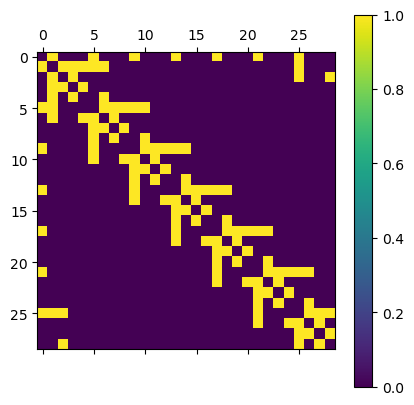

In [5]:
plt.matshow(A.todense()); plt.colorbar();

Similarly, we can construct a degree matrix, which contains the number of connections attached to each vertex. As we can see for central notes this is 7 (the parameter `p` of the tiling), whereas for boundary points it can be fewer than p.

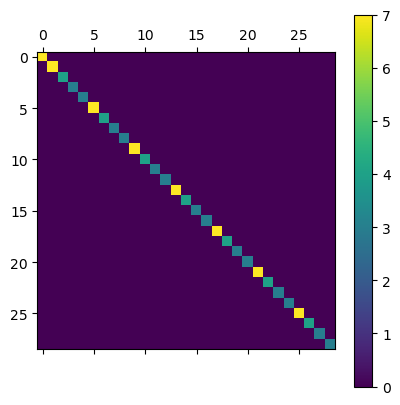

In [6]:
G = ht.operators.degree(nbrs)

plt.matshow(G.todense()); plt.colorbar();

We are now prepared to build a Laplacian for our lattice ...

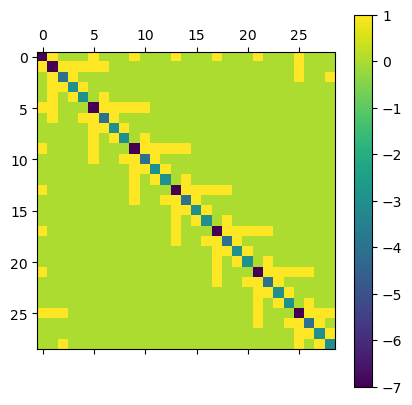

In [7]:
A = ht.operators.adjacency(nbrs)
G = ht.operators.degree(nbrs)

D = A - G

plt.matshow(D.todense()); plt.colorbar();

... as well as a Helmholtz operator containting a mass term. We also added weights for the Laplacian part. In case we want to use constant weights, it is enought to multiply them as a factor. For vertex-dependend weights the weight keyword provided by `operators.adjacency` and `operators.degree` can be used.

In [8]:
w = 2 # weight
m = 5 # mass

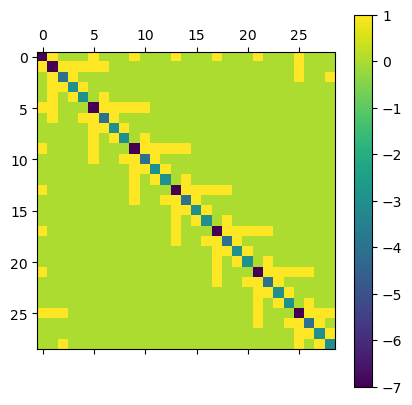

In [9]:
A = ht.operators.adjacency(nbrs)
G = ht.operators.degree(nbrs)
I = ht.operators.identity(nbrs)  # identical: sp.sparse.identity(len(T))

H = w*(A - G) - m*I


plt.matshow(D.todense()); plt.colorbar();

## Dirichlet boundary

In [10]:
from hypertiling.graphics.svg import make_svg, draw_svg

The operator functions provide the `boundary` keyword which takes a boolean array, encoding whether a vertex is considered a boundary vertex. For boundary points, the corresponding rows in the matrix are left empty, it therefore becomes non-symmetric. This way it is ensured that the boundary point act on their interiour neighbours, but stay themselves constant (Dirichlet boundary)

We use a helper function to determine at which maximal radial distance the lattice can be divded into a closed boundary and interiour bulk nodes

In [11]:
def radial_distance_polar(z):
    return np.abs(z)

def establish_boundary(tiling, cutoff_radius):
    boundary = np.zeros(len(T)).astype("bool")
    for j in range(len(T)):
        if radial_distance_polar(T.get_center(j)) > cutoff_radius:
            boundary[j] = True
    return boundary

In [12]:
T = ht.HyperbolicTiling(7,3,6)

boundary = establish_boundary(T, cutoff_radius = 0.975)

This is an example; boundary cells are plotted in black, bulk cells in white color

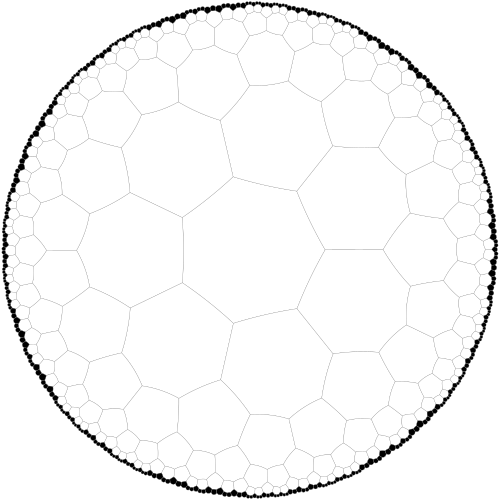

In [13]:
svg = make_svg(T, boundary.astype("int"), cmap="Greys", edgecolor="grey", lw=0.1)
draw_svg(svg)

## Helmholtz equation

Now we are ready to solve a Helmholtz equation in the bulk region of a hyperbolic lattice

In [14]:
T = ht.HyperbolicTiling(7,3,6)

# locate boundary
boundary = establish_boundary(T, cutoff_radius = 0.975)

# extract neighbours
nbrs = T.get_nbrs_list()

# cut away boundary in one quadrant; those cells belong to the bulk region now
for i in range(len(T)):
        if T.get_angle(i) < np.deg2rad(90):
            boundary[i] = False

bulk = np.invert(boundary)

# mass parameter
m = 1

# weights
weights = [list(np.random.rand(len(nb))+5) for nb in nbrs] # some random weights between [4,5]

In [15]:
# construct discrete differential operator
A = ht.operators.adjacency(nbrs, weights, boundary=boundary)  # Adjacency matrix
G = ht.operators.degree(nbrs, weights, boundary=boundary)     # Degree matrix   
D = A-G                                                       # Laplacian 
M = m*ht.operators.identity(nbrs, boundary=boundary)          # Mass matrix
B = sp.sparse.diags(boundary.astype("int"))                   # Boundary matrix

H = D - M + B  # Helmholtzian

Reminder: The boundary is included as trivial lines in the operator matrix; in some literature this approach is refered to as "ghost cells"; they are not updated but affect their bulk neighbours

The right hand side of the resulting linear system thus carries precisely the Dirichlet boundary values for those sites

Now are ready to solve the linear system $Hx=y$, where $H$ is the differential operator, $x$ is the solution vector and $y$ is the right hand side (`rhs`). We use the GMRES solver (Generalized minimal residual method).

In [16]:
from scipy.sparse.linalg import gmres

In [17]:
rhs = boundary.astype("int") # right hand side
x0 = np.ones(len(T))         # initial guess

sol, _ = gmres(H, rhs, x0=x0) # solve

Boundary cells at angles between 90 and 360 degrees have been fixed to a value of 1 (dark blue), whereas all remaining cells (including the boundary between 0 and 90 degress) have been left free. The colormap is roughly symmetric, hence white cells have a value of 0 and dark red cells a value of -1.

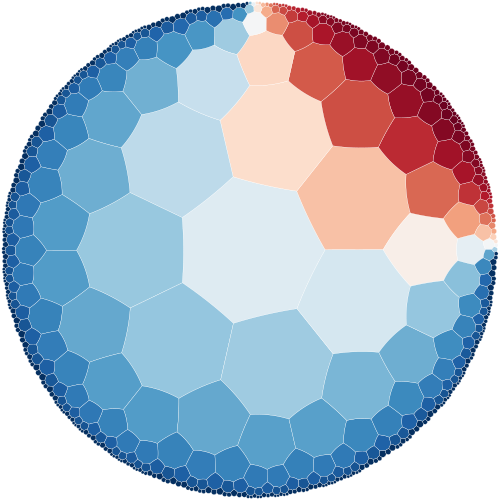

In [18]:
svg = make_svg(T, sol, cmap="RdBu", edgecolor="white", lw=0.1)
draw_svg(svg)

## Laplace equation

Now we model an electrostatic problem, where the boundary nodes are held to a fixed electric potential

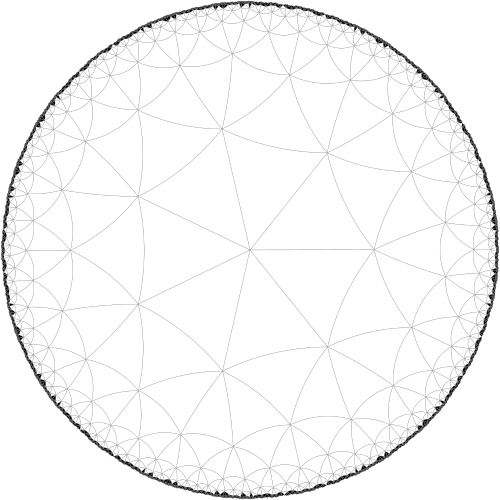

In [19]:
T = ht.HyperbolicTiling(3,7,6, center="vertex")

boundary = establish_boundary(T, cutoff_radius = 0.982)

svg = make_svg(T, boundary.astype("int"), cmap="Greys", edgecolor="grey", lw=0.1)
draw_svg(svg)

In [20]:
# extract neighbours
nbrs = T.get_nbrs_list(method="RO")

weights = [list(np.random.rand(len(nb))+5) for nb in nbrs] # some random weights between [4,5]

In [21]:
# construct discrete differential operator
A = ht.operators.adjacency(nbrs, weights, boundary=boundary)  # Adjacency matrix
G = ht.operators.degree(nbrs, weights, boundary=boundary)     # Degree matrix   
D = A-G                                                       # Laplacian 
B = sp.sparse.diags(boundary.astype("int"))                   # Boundary matrix

H = D + B  # Laplacian

Build Dirichlet boundary and solve Laplace equation in the bulk

In [22]:
# some regions are fixed to a value of 1, some to a value of -1
rhs = boundary.astype("int")
for i in range(len(T)):
    if boundary[i]:
        if T.get_angle(i) < np.deg2rad(150):
            rhs[i] = -1
        if np.deg2rad(180) < T.get_angle(i) < np.deg2rad(220):
            rhs[i] = -1
            
x0 = np.ones(len(T)) # initial guess

sol, _ = gmres(H, rhs, x0=x0, tol=1e-2)  # solve

Plot the result. This time we fixed the entire boundary to values of either -1 (red) or +1 (blue). In the interiour of the lattice, the Laplace equation provides a nice, smooth solution (electrostatic potential).

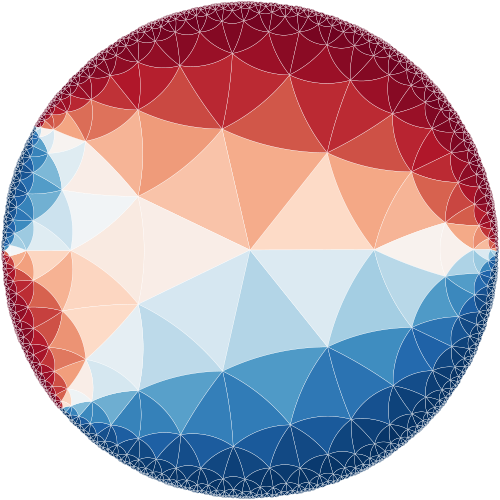

In [23]:
svg = make_svg(T, sol, cmap="RdBu", edgecolor="white", lw=0.1)
draw_svg(svg)

## Refinement

In [28]:
T = ht.HyperbolicTiling(3,7,6, center="vertex")

T.refine_lattice(1)        
        
for i, poly in enumerate(T):
    angle = np.angle(T.get_center(i))
    polygon = T.get_polygon(i)
    if angle > 0:
        polygon.angle = angle
    else:
        polygon.angle = angle + 2*np.pi
        
        
boundary = establish_boundary(T, cutoff_radius = 0.982)

In [29]:
# extract neighbours
nbrs = T.get_nbrs_list(method="RO", radius=0.3)

weights = [list(np.random.rand(len(nb))+100) for nb in nbrs] # some random weights ~ 20

In [30]:
# construct discrete differential operator
A = ht.operators.adjacency(nbrs, weights, boundary=boundary)  # Adjacency matrix
G = ht.operators.degree(nbrs, weights, boundary=boundary)     # Degree matrix   
D = A-G                                                       # Laplacian 
M = ht.operators.identity(nbrs, boundary=boundary)          # Mass matrix
B = sp.sparse.diags(boundary.astype("int"))                   # Boundary matrix

In [31]:
# some regions are fixed to a value of 1, some to a value of -1
rhs = boundary.astype("int")
for i in range(len(T)):
    if boundary[i]:
        if np.deg2rad(14) < T.get_angle(i) < np.deg2rad(140):
            rhs[i] = -1
        if np.deg2rad(203) < T.get_angle(i) < np.deg2rad(261):
            rhs[i] = -1
            
x0 = np.ones(len(T)) # initial guess

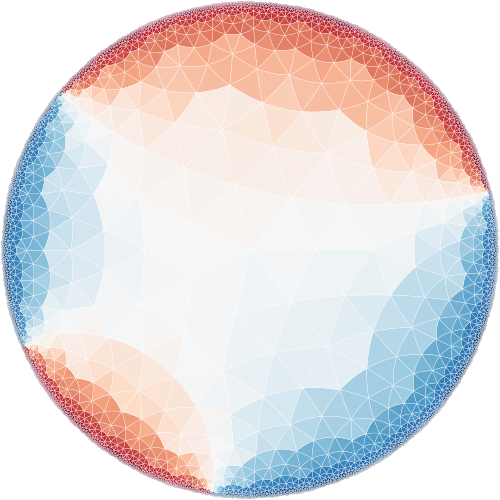

In [32]:
m = 1
H = D - m *M + B  # Helmholtzian

sol, _ = gmres(H, rhs, x0=x0, tol=1e-2)  # solve

svg = make_svg(T, sol, cmap="RdBu", edgecolor="white", lw=0.1) # plot
draw_svg(svg)